<center>
    <h1>Projet DLA</h1>
    <h2>Style Transfer Using Convolutional Neural Network</h2>   
</center>

## Import modules 

In [1]:
import torch
import torchvision
from torchvision import transforms
from torchvision import models
from torchvision.models import vgg19, VGG19_Weights
import torch.nn.functional as F
import torch.nn as nn

import torch.optim as optim
import copy

from PIL import Image
import matplotlib.pyplot as plt

## Load and display images 

In [2]:
# use cuda if it is available for GPU training otherwise it will use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# shape of the output image
imshape = (224, 224)

def image_loader(image_name):
    # scale imported image
    # transform it into a torch tensor
    loader = transforms.Compose([transforms.Resize(imshape),  transforms.ToTensor()])

    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)   # add an additional dimension for fake batch (here 1)
    return image.to(device, torch.float) # move the image tensor to the correct device

def image_display(tensor, title=None):
    unloader = transforms.ToPILImage()  # reconvert into PIL image
    image = tensor.cpu().clone()        # clone the tensor
    image = unloader(image.squeeze(0))  # remove the fake batch dimension
    plt.show()
    plt.imshow(image)
    if title is not None:
        plt.title(title)

Content image shape : 224 x 224
Style image shape : 224 x 224
torch.Size([1, 3, 224, 224])


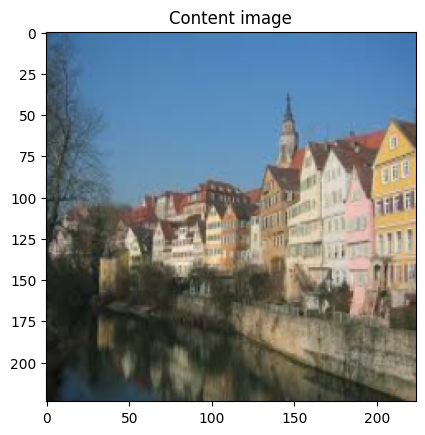

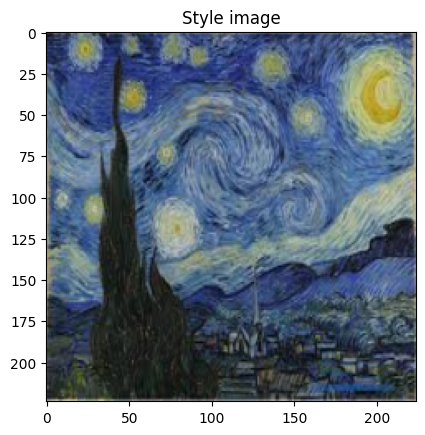

In [3]:
image_path = "../data/"
content_image_name = "content.jpeg"
style_image_name = "style.jpeg"

content_image = image_loader(image_path + content_image_name)
style_image = image_loader(image_path + style_image_name)

content_height, content_width = content_image.shape[2], content_image.shape[3]
style_height, style_width = style_image.shape[2], style_image.shape[3]

print(f"Content image shape : {content_height} x {content_width}")
print(f"Style image shape : {style_height} x {style_width}")
print(content_image.size())
image_display(content_image, "Content image")
image_display(style_image, "Style image")

### Load the VGG-19 pretrained model 

In [4]:
# importing the VGG 19 model with pre-trained weights
model = models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1).to(device) # move the model to the correct device

<center><h2>Style Transfer Method</h2></center>

In [5]:
print("Features layers :")
print(model.children())

Features layers :
<generator object Module.children at 0x15ece0110>


In [6]:
print("Classification layers:")
print(model.classifier)

Classification layers:
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


***Note*** :  In our case, classification layers are not necessary, as style transfer does not require class prediction, but only the extraction of visual features.

In [7]:
def get_content_loss(input, target):
    return F.mse_loss(input, target)

def gram_matrix(input):
    a, b, c, d = input.size()  
    # a = batch size, 
    # b = number of feature maps, 
    # c, d = height, width
    features = input.view(a * b, c * d)   # flatten the feature maps
    G = torch.mm(features, features.t())  # compute the dot product of the feature maps
    return G.div(a * b * c * d)           # normalize the Gram matrix

def get_style_loss(input, target):
    G_input = gram_matrix(input)
    G_target = gram_matrix(target)
    return F.mse_loss(G_input, G_target)

***Note*** : We need to implement the loss functions as custom layers in the neural network model. It allows for easy incorporation into an nn.Sequential model.

In [8]:
# We use the PyTorch module made by Alexis Jacq for Neural Style Transfer components
class ContentLoss(nn.Module):
    """
    Computes the content loss between the input and the target feature maps.

    Attributes:
    ------------
    target : torch.Tensor
        The target feature map (detached to avoid gradient computation).

    Methods:
    ---------
    forward(input):
        Computes the content loss using the input feature map.
        Returns the input for compatibility with sequential models.
    """

    def __init__(self, target):
        """
        Initializes the ContentLoss module.

        Parameters:
        ------------
        target : torch.Tensor
            The target feature map from a specific layer of the model.
        """
        super(ContentLoss, self).__init__()
        self.target = target.detach()  # Detach target to avoid affecting gradients

    def forward(self, input):
        """
        Computes the content loss between the input and the target feature map.

        Parameters:
        ------------
        input : torch.Tensor
            The input feature map from the same layer.

        Returns:
        ------------
        torch.Tensor
            The unchanged input feature map (needed for seamless integration in the model).
        """
        self.loss = get_content_loss(input, self.target)  # Store the loss
        return input  # Pass the input through unchanged


class StyleLoss(nn.Module):
    """
    Computes the style loss between the input and the target feature maps.

    Attributes:
    ------------
    target : torch.Tensor
        The target feature map (detached to avoid gradient computation).

    Methods:
    ---------
    forward(input):
        Computes the style loss using the input feature map.
        Returns the input for compatibility with sequential models.
    """

    def __init__(self, target_feature):
        """
        Initializes the StyleLoss module.

        Parameters:
        ------------
        target_feature : torch.Tensor
            The target feature map used for style loss computation.
        """
        super(StyleLoss, self).__init__()
        self.target = target_feature.detach()  # Detach target to avoid affecting gradients

    def forward(self, input):
        """
        Computes the style loss between the input and the target feature map.

        Parameters:
        ------------
        input : torch.Tensor
            The input feature map from the same layer.

        Returns:
        ------------
        torch.Tensor
            The unchanged input feature map (needed for seamless integration in the model).
        """
        self.loss = get_style_loss(input, self.target)  # Store the loss
        return input  # Pass the input through unchanged


class Normalization(nn.Module):
    """
    Normalizes an image using the mean and standard deviation of the dataset.

    Attributes:
    ------------
    mean : torch.Tensor
        The mean values for each channel (reshaped to match image dimensions).
    std : torch.Tensor
        The standard deviation values for each channel (reshaped to match image dimensions).

    Methods:
    ---------
    forward(img):
        Normalizes the input image tensor using the mean and standard deviation.
    """

    def __init__(self, mean, std):
        """
        Initializes the Normalization module.

        Parameters:
        ------------
        mean : list or torch.Tensor
            The mean values for each channel (e.g., for ImageNet: [0.485, 0.456, 0.406]).
        std : list or torch.Tensor
            The standard deviation values for each channel (e.g., for ImageNet: [0.229, 0.224, 0.225]).
        """
        super(Normalization, self).__init__()
        # Convert mean and std to tensors and reshape for broadcasting across the image dimensions
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        """
        Normalizes the input image.

        Parameters:
        ------------
        img : torch.Tensor
            The input image tensor to be normalized.

        Returns:
        ------------
        torch.Tensor
            The normalized image tensor.
        """
        return (img - self.mean) / self.std  # Apply normalization


In [9]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv4_2']
style_layers_default = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

In [10]:
# Copy our model to iterate on the layers after
model = model.features.eval() # set the model to evaluation mode

vgg = copy.deepcopy(model)

# Define the normalization parameters based on the values 
# recommended in the PyTorch VGG-19 model documentation.
model_normalization_mean = [0.485, 0.456, 0.406]
model_normalization_std = [0.229, 0.224, 0.225]

# Create a normalization layer with specified mean and std
normalization = Normalization(model_normalization_mean, model_normalization_std).to(device)
# Add the layer to our model
model = nn.Sequential(normalization)

In [11]:
blocks = [2, 2, 4, 4, 4]  # Number of convolutional layers in each block of the VGG-19 model

# Renommer les couches
style_losses = []
content_losses = []
index_conv = 0
index_relu = 0
current_block = 0
i = 0

for layer in vgg.children():
    # Vérifier si on doit passer au bloc suivant
    if current_block < len(blocks) and index_conv == blocks[current_block]:
        index_conv = 0  # Réinitialiser le compteur pour le nouveau bloc
        current_block += 1

    if isinstance(layer, nn.Conv2d):  # Pour les couches convolutionnelles
        index_conv += 1
        name = f'conv{current_block + 1}_{index_conv}'

        if name in content_layers_default:
            # add content loss:
            target = model(content_image).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers_default:
            
            # add style loss:
            target_feature = model(style_image).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
        
    elif isinstance(layer, nn.ReLU):  # Pour les couches ReLU
        index_relu += 1
        name = f'relu{current_block + 1}_{index_relu}'

    elif isinstance(layer, nn.MaxPool2d):  # Pour les couches MaxPooling
        name = f'pool{current_block + 1}'
    
    i += 1
    model.add_module(name, layer)

# Afficher les premières couches pour vérifier les noms
print(model)

Sequential(
  (0): Normalization()
  (style_loss_0): StyleLoss()
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_1): ReLU(inplace=True)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (style_loss_5): StyleLoss()
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_3): ReLU(inplace=True)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_4): ReLU(inplace=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (style_loss_10): StyleLoss()
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_5): ReLU(inplace=True)
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_6): ReLU(inplace=True)
  (conv3_3): Conv2d(256, 256, 

In [12]:
for name, layer in model.named_children():
    print(name, layer)

0 Normalization()
style_loss_0 StyleLoss()
conv1_1 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
relu1_1 ReLU(inplace=True)
conv1_2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
relu2_2 ReLU(inplace=True)
pool2 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
style_loss_5 StyleLoss()
conv2_1 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
relu2_3 ReLU(inplace=True)
conv2_2 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
relu3_4 ReLU(inplace=True)
pool3 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
style_loss_10 StyleLoss()
conv3_1 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
relu3_5 ReLU(inplace=True)
conv3_2 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
relu3_6 ReLU(inplace=True)
conv3_3 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
relu3_7 ReLU(inplace=True)
conv3_4 Conv2d(256, 256, kern

In [13]:
# Since the last layer is a loss function, we iterate from the end of the model
# and stop when we encounter the first content or style loss layer.
for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
model = model[:i + 1]

In [14]:
for name, layer in model.named_children():
    print(name, layer)

0 Normalization()
style_loss_0 StyleLoss()
conv1_1 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
relu1_1 ReLU(inplace=True)
conv1_2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
relu2_2 ReLU(inplace=True)
pool2 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
style_loss_5 StyleLoss()
conv2_1 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
relu2_3 ReLU(inplace=True)
conv2_2 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
relu3_4 ReLU(inplace=True)
pool3 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
style_loss_10 StyleLoss()
conv3_1 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
relu3_5 ReLU(inplace=True)
conv3_2 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
relu3_6 ReLU(inplace=True)
conv3_3 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
relu3_7 ReLU(inplace=True)
conv3_4 Conv2d(256, 256, kern

***Note*** : we only need the layers from the model that are required for computing the content and style losses. Let's just keep them. 

Let's define alpha (style weight) and beta (content weight) as below : 

$$\mathcal{L}_{\text{total}} = \alpha \mathcal{L}_{\text{content}} + \beta \mathcal{L}_{\text{style}}$$


In [15]:
style_weight = 1000000
content_weight = 1

<Figure size 640x480 with 0 Axes>

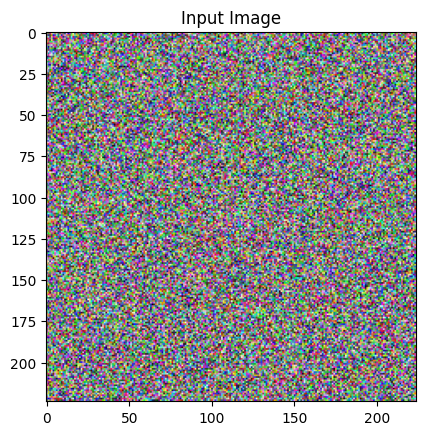

In [16]:
# The initialization of the image is a random noise
input_image = torch.randn(content_image.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
image_display(input_image, title='Input Image')

In [17]:
# as in the thesis, we choose L-BFGS for the optimization
optimizer = optim.LBFGS([input_image.requires_grad_()])

In [18]:
num_steps = 10000

step_counter = [0]
while step_counter[0] <= num_steps:

    # Recall function for the optimiser
    def closure():

        optimizer.zero_grad()     # do not accumulate parameter gradients
        model(input_image)        # passes the image as input to the model
        style_score = 0
        content_score = 0

        # add up the losses for each style layer
        for style_loss in style_losses:
            style_score += style_loss.loss

        # add up the losses for each content layer
        for content_loss in content_losses:
            content_score += content_loss.loss

        # apply the weights
        style_score *= style_weight
        content_score *= content_weight

        loss = style_score + content_score # calculate the total loss
        loss.backward()                    # backward to calculate the gradients of the input image

        step_counter[0] += 1

        if step_counter[0] % 50 == 0:      # display style and content scores every 50 steps
            print("step {}:".format(step_counter[0]))
            print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                style_score.item(), content_score.item()))
            print()

        return style_score + content_score

    optimizer.step(closure)

input_image.data.clamp_(0, 1)


step 50:
Style Loss : 36.287704 Content Loss: 17.657658

step 100:
Style Loss : 13.977160 Content Loss: 15.883114

step 150:
Style Loss : 8.928306 Content Loss: 14.727010

step 200:
Style Loss : 6.803953 Content Loss: 13.882628

step 250:
Style Loss : 5.678434 Content Loss: 13.128166

step 300:
Style Loss : 5.046512 Content Loss: 12.594808

step 350:
Style Loss : 4.629919 Content Loss: 12.135605

step 400:
Style Loss : 4.329411 Content Loss: 11.771143

step 450:
Style Loss : 4.116477 Content Loss: 11.475368

step 500:
Style Loss : 3.966586 Content Loss: 11.227280

step 550:
Style Loss : 3.852676 Content Loss: 11.001381

step 600:
Style Loss : 3.753577 Content Loss: 10.819290

step 650:
Style Loss : 3.669217 Content Loss: 10.659921

step 700:
Style Loss : 3.601036 Content Loss: 10.511592

step 750:
Style Loss : 3.540344 Content Loss: 10.388789

step 800:
Style Loss : 3.486177 Content Loss: 10.300805

step 850:
Style Loss : 3.443865 Content Loss: 10.223784

step 900:
Style Loss : 3.40412

tensor([[[[0.7360, 0.7760, 0.7883,  ..., 0.7674, 0.8366, 0.9459],
          [0.1899, 0.2208, 0.1657,  ..., 0.4137, 0.7001, 0.6646],
          [0.0385, 0.1482, 0.0000,  ..., 0.3017, 0.6164, 0.7192],
          ...,
          [0.0888, 0.0861, 0.0452,  ..., 0.0212, 0.3860, 0.5127],
          [0.0787, 0.2280, 0.1989,  ..., 0.2055, 0.4151, 0.4375],
          [0.5116, 0.6006, 0.4382,  ..., 0.1930, 0.3059, 0.6288]],

         [[0.7859, 0.8442, 0.8055,  ..., 0.8668, 0.9445, 1.0000],
          [0.1897, 0.1587, 0.1914,  ..., 0.5216, 0.6766, 0.7682],
          [0.1232, 0.1560, 0.0477,  ..., 0.3543, 0.6435, 0.8611],
          ...,
          [0.0962, 0.0879, 0.1351,  ..., 0.1816, 0.3902, 0.6004],
          [0.1608, 0.2863, 0.2447,  ..., 0.1912, 0.3368, 0.5130],
          [0.6412, 0.5204, 0.5197,  ..., 0.3250, 0.3696, 0.7183]],

         [[0.7440, 0.8830, 0.8184,  ..., 0.8558, 0.8871, 1.0000],
          [0.2209, 0.1003, 0.3824,  ..., 0.6653, 0.5332, 0.8240],
          [0.2722, 0.0948, 0.2093,  ..., 0

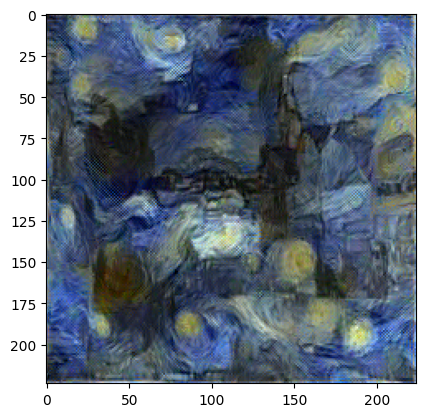

In [19]:
image_display(input_image)